<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loading-and-error-computation" data-toc-modified-id="Data-loading-and-error-computation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loading and error computation</a></span></li><li><span><a href="#Global-error" data-toc-modified-id="Global-error-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global error</a></span></li><li><span><a href="#Per-series-error" data-toc-modified-id="Per-series-error-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Per series error</a></span></li><li><span><a href="#Per-decade-error" data-toc-modified-id="Per-decade-error-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Per decade error</a></span></li><li><span><a href="#Per-document-error" data-toc-modified-id="Per-document-error-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Per document error</a></span></li></ul></div>

## Data loading and error computation

A few notes on how the errors are computed.

The errors for the character and word level are the Levenshtein distance (cf. [here](https://en.wikipedia.org/wiki/Levenshtein_distance) and [here](https://en.wikipedia.org/wiki/Word_error_rate)) which is standard in OCR performance.

A line is considered as false if it contains at least a word error.

In [115]:
import pandas as pd
import json
from glob import glob
import numpy as np
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
from IPython.display import display, HTML
import editdistance
from wer import wer
editdistance_vectorized = np.vectorize(editdistance.eval)

df_rep = pd.read_excel('repertoires.xlsx')
df_rep.dropna(subset=['nom_court'], inplace=True)
df_rep['document'] = df_rep['lien_source'].str.replace('https://gallica.bnf.fr/ark:/12148/', '')
df_rep['vue_debut'] = df_rep['vue_debut'].astype(int)
df_rep['annee'] = df_rep['annee'].astype(int)
df_rep['decade'] = df_rep['annee'] - df_rep['annee'] % 10
# df_rep['annee'] = pd.to_datetime(df_rep['annee'].astype(int), format='%Y')
df_rep.set_index('document', inplace=True)

def index_from_boolean(series):
    return series.where(series).dropna().index

verified = glob('verified/fait*.xlsx')
dfs = []
for v in verified:
    splits = v.split('_')
    doc_id = splits[-2]
    page = int(splits[-1].split('.')[0])
    df_stat = pd.read_excel(v).iloc[2:, [0,3]]
    df_stat['document'] = doc_id
    df_stat['page'] = page
    dfs.append(df_stat)
    
df_verified = pd.concat(dfs).set_index(['document', 'page'])
df_verified['line'] = df_verified.groupby(['document', 'page']).cumcount()
df_verified = df_verified.reset_index().set_index(['document', 'page', 'line'])

df_rows = pd.read_pickle('df_rows.pickle')
df_rows['line'] = df_rows.groupby(['document', 'page']).cumcount()
df_rows = df_rows.reset_index().set_index(['document', 'page', 'line'])

df_errors = df_verified.join(df_rows, rsuffix='_raw')
df_errors = df_errors.join(df_rep[['nom_court', 'annee', 'decade']])
df_errors['words'] = df_errors['text'].str.split()
df_errors['words_raw'] = df_errors['text_raw'].str.split()
df_errors['num_words'] = df_errors['words'].apply(len)
df_errors['num_words_raw'] = df_errors['words_raw'].apply(len)

df_errors['character_errors'] = editdistance_vectorized(df_errors['text'], df_errors['text_raw'])
df_errors['character_error_rate'] = df_errors['character_errors']/df_errors['text'].apply(len)*100

df_errors['word_errors'] = df_errors.apply(lambda row: wer(row['words'], row['words_raw']), axis=1)
df_errors['word_error_rate'] = df_errors['word_errors']/df_errors['num_words']*100
df_errors['line_error'] = df_errors['word_errors'] > 0

In [222]:
df_per_doc = ((df_errors.groupby('document')['character_errors'].sum()/df_errors.groupby('document')['text'].apply(len).sum()*100).to_frame('character_error_rate')
    .join((df_errors.groupby('document')['word_errors'].sum()/df_errors.groupby('document')['num_words'].sum()*100).to_frame('word_errors_rate'))         
    .join((df_errors.groupby(['document', 'page'])['line_error'].sum().groupby('document').sum()/df_errors.groupby(['document', 'page']).size().groupby('document').sum()*100).to_frame('line_error_rate')))

## Global error

Global error on the whole series (not per page or per document).

Three kinds of errors:
- Error per character
- Error per word
- Error per line

,character_error_rate
count,4132.000000
mean,5.615422
std,11.900583
min,0.000000
25%,0.000000
50%,0.000000
75%,6.666667
max,233.333333


There is 3 line with an character_error_rate bigger than 100%


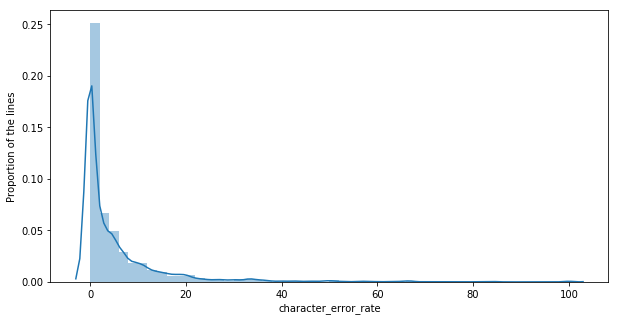

In [236]:
display(df_errors['character_error_rate'].describe().to_frame())
print("There is %d line with an character_error_rate bigger than 100%%"%(df_errors['character_error_rate']>100).sum())
plt.figure(figsize=(10,5))
plt.xlabel('Percentage of errors per character')
plt.ylabel('Proportion of the lines')
sns.distplot(df_errors['character_error_rate'][df_errors['character_error_rate'] <= 100]);

,word_error_rate
count,4132.000000
mean,18.724938
std,28.135552
min,0.000000
25%,0.000000
50%,0.000000
75%,28.571429
max,300.000000


There is 24 line with an word_error_rate bigger than 100%


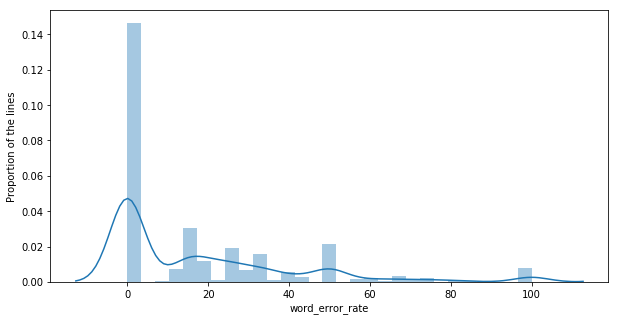

In [237]:
display(df_errors['word_error_rate'].describe().to_frame())
print("There is %d line with an word_error_rate bigger than 100%%"%(df_errors['word_error_rate']>100).sum())
plt.figure(figsize=(10,5))
plt.xlabel('Percentage of errors per word')
plt.ylabel('Proportion of the lines')
sns.distplot(df_errors['word_error_rate'][df_errors['word_error_rate'] <= 100]);

In [24]:
print('The rate of line with error is of %.3f%%'%((df_errors['character_errors'] > 0).sum()/len(df_errors) * 100))

The rate of line with error is of 49.831%


Globally the rate of error is quite high, particularly if we consider the word error rate. It means that for each entry we have that is composed of minimum 4 words, we have at least an error. So we could potentially have no correct entries.

## Per series error

The error is now computed at the series level.

In [95]:
df_rep_stats = df_rep.groupby('nom_court')['annee'].agg(['first', 'last', 'count']).sort_values(by='first')
df_rep_stats

,first,last,count
nom_court,,,
Annuaire-general-du-commerce,1839,1856,17
Annuaire-Didot-Bottin,1857,1907,36
Annuaire du commerce Didot-Bottin,1914,1922,3


,Annuaire-general-du-commerce,Annuaire-Didot-Bottin,Annuaire du commerce Didot-Bottin
count,1660.000000,1834.000000,638.000000
mean,2.841719,6.001641,11.722035
std,9.527233,10.986513,16.639979
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.040816
50%,0.000000,2.222222,5.882353
75%,3.030303,7.142857,14.285714
max,233.333333,140.000000,100.000000


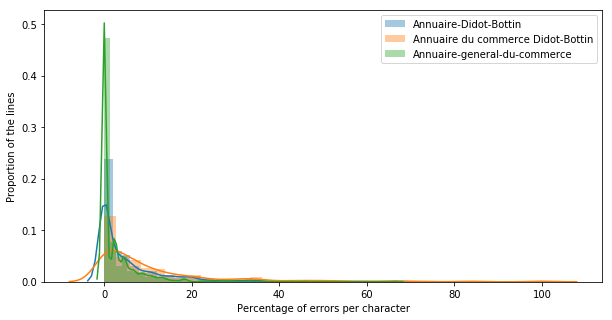

In [238]:
dfs = []
plt.figure(figsize=(10,5));
for (name, group) in df_errors.groupby('nom_court', sort=False):
    dfs.append(group['character_error_rate'].describe().to_frame(name))
    sns.distplot(group['character_error_rate'][group['character_error_rate'] <= 100], label=name);
plt.legend()
plt.xlabel('Percentage of errors per character')
plt.ylabel('Proportion of the lines')
pd.concat(dfs, axis=1)[df_rep_stats.index]

,Annuaire-general-du-commerce,Annuaire-Didot-Bottin,Annuaire du commerce Didot-Bottin
count,1660.000000,1834.000000,638.000000
mean,11.777517,20.972633,30.340055
std,20.911168,30.633369,31.922710
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,11.111111
50%,0.000000,12.500000,20.000000
75%,20.000000,33.333333,42.857143
max,300.000000,300.000000,200.000000


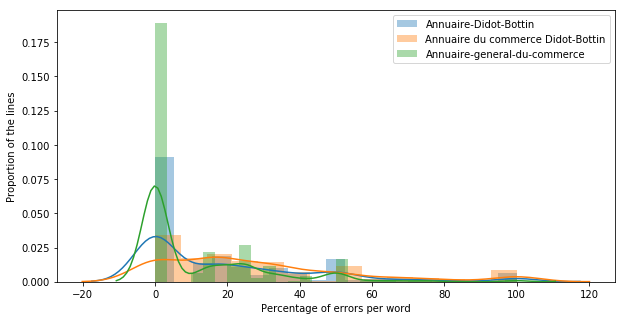

In [239]:
dfs = []
plt.figure(figsize=(10,5))
for (name, group) in df_errors.groupby('nom_court', sort=False):
    dfs.append(group['word_error_rate'].describe().to_frame(name))
    sns.distplot(group['word_error_rate'][group['word_error_rate'] <= 100], label=name);
plt.legend()
plt.xlabel('Percentage of errors per word')
plt.ylabel('Proportion of the lines')
pd.concat(dfs, axis=1)[df_rep_stats.index]

In [162]:
lines_errors = []
for (name, group) in df_errors.groupby('nom_court'):
    lines_errors.append({'series' :name, 'line_error':(group['character_errors'] > 0).sum()/len(group) * 100})
pd.DataFrame(lines_errors).set_index('series').loc[df_rep_stats.index]

,line_error
nom_court,
Annuaire-general-du-commerce,37.048193
Annuaire-Didot-Bottin,52.290076
Annuaire du commerce Didot-Bottin,76.018809


We can see that the "Annuaire-general-du-commerce" has a better overall quality of OCR, whereas the "Annuaire du commerce Didot-Bottin" is very poorly transcribed.

## Per decade error

This time the level is of the decade, it should however be noted that because the sample size is so small (1 sample per decade), no big conclusions should be made...

,Num annuaire per decade
decade,
1830,1
1840,1
1850,2
1880,1
1900,1
1920,1


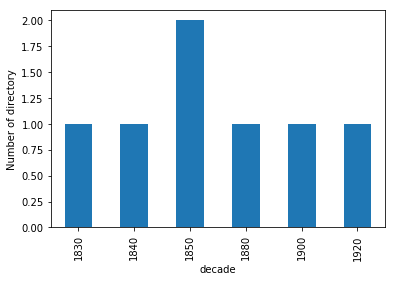

In [254]:
df_rep_count_per_decade = df_rep.loc[df_errors.reset_index(level=[1,2]).index.unique().values].groupby('decade').size().to_frame('Num annuaire per decade')
df_rep_count_per_decade.plot(kind='bar', legend=False);
plt.ylabel('Number of directory')
df_rep_count_per_decade

,1830,1840,1850,1880,1900,1920
count,546.000000,558.000000,1112.000000,634.000000,644.000000,638.000000
mean,3.515697,3.630358,2.230993,7.278351,7.272693,11.722035
std,11.290843,6.556041,8.578532,11.131527,13.103175,16.639979
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.040816
50%,0.000000,0.000000,0.000000,3.225806,2.380952,5.882353
75%,4.545455,4.545455,2.325581,10.000000,9.302326,14.285714
max,233.333333,45.833333,228.571429,100.000000,140.000000,100.000000


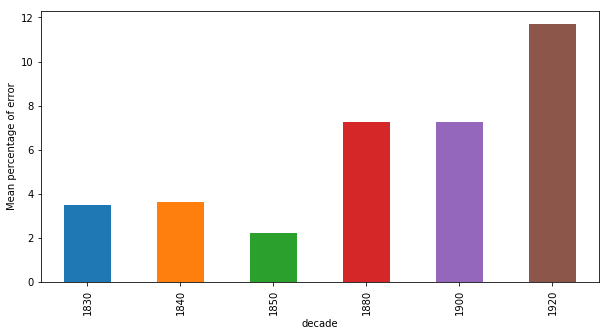

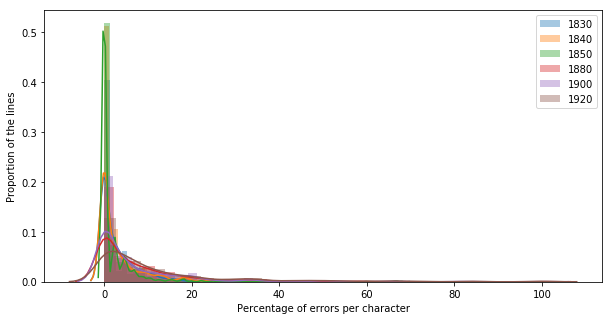

In [264]:
dfs = []
plt.figure(figsize=(10,5))
plt.xlabel('Decade')
plt.ylabel('Mean percentage of error')
df_errors.groupby('decade')['character_error_rate'].mean().plot(kind='bar')

plt.figure(figsize=(10,5))
for (name, group) in df_errors.groupby('decade'):
    dfs.append(group['character_error_rate'].describe().to_frame(name))
    sns.distplot(group['character_error_rate'][group['character_error_rate'] <= 100], label=str(name));
plt.legend()
plt.xlabel('Percentage of errors per character')
plt.ylabel('Proportion of the lines')
pd.concat(dfs, axis=1)

,1830,1840,1850,1880,1900,1920
count,546.000000,558.000000,1112.000000,634.000000,644.000000,638.000000
mean,14.732695,14.793267,10.229745,25.994317,21.521616,30.340055
std,23.120570,20.872808,21.873514,29.647321,34.758807,31.922710
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,11.111111
50%,0.000000,0.000000,0.000000,16.666667,14.285714,20.000000
75%,25.000000,25.000000,16.666667,50.000000,29.761905,42.857143
max,300.000000,100.000000,300.000000,160.000000,300.000000,200.000000


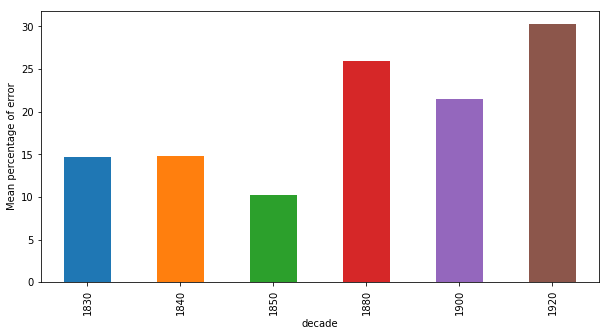

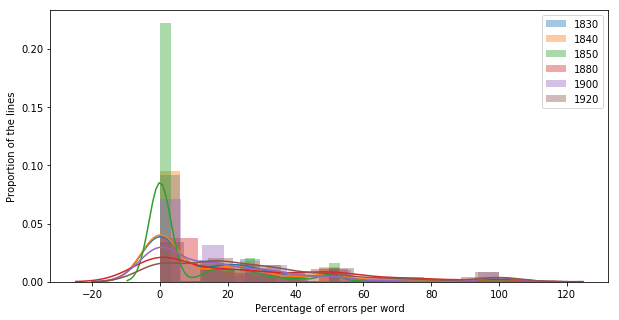

In [265]:
dfs = []
plt.figure(figsize=(10,5))
plt.xlabel('Decade')
plt.ylabel('Mean percentage of error')
df_errors.groupby('decade')['word_error_rate'].mean().plot(kind='bar')

plt.figure(figsize=(10,5))
for (name, group) in df_errors.groupby('decade'):
    dfs.append(group['word_error_rate'].describe().to_frame(name))
    sns.distplot(group['word_error_rate'][group['word_error_rate'] <= 100], label=str(name));
plt.legend()
plt.xlabel('Percentage of errors per word')
plt.ylabel('Proportion of the lines')
pd.concat(dfs, axis=1)

In [214]:
lines_errors = []
for (name, group) in df_errors.groupby('decade'):
    lines_errors.append({'series' :name, 'line_error':(group['character_errors'] > 0).sum()/len(group) * 100})
pd.DataFrame(lines_errors).set_index('series')

,line_error
series,
1830,46.153846
1840,44.086022
1850,30.845324
1880,58.675079
1900,56.055901
1920,76.018809


We still see an overall augmentation of the error rates, which corresponds to what was observed in the series.

## Per document error

In this part, we individually observe each document and its mean error rates.

In [234]:
df_per_doc.join(df_rep[['annee']]).sort_values(by='annee').reset_index().set_index(['document', 'annee'])

,,character_error_rate,word_errors_rate,line_error_rate
document,annee,,,
bpt6k63243601,1839,12.754114,12.723130,46.153846
bpt6k6315927h,1848,16.166505,14.330218,44.086022
bpt6k6314752k,1856,5.227493,5.403405,21.043165
bpt6k6305463c,1857,11.737657,13.272311,40.467626
bpt6k9764647w,1881,36.979671,25.709516,58.675079
bpt6k9776121t,1907,26.016457,14.235501,56.055901
bpt6k97774838,1921,53.000968,24.978735,76.018809


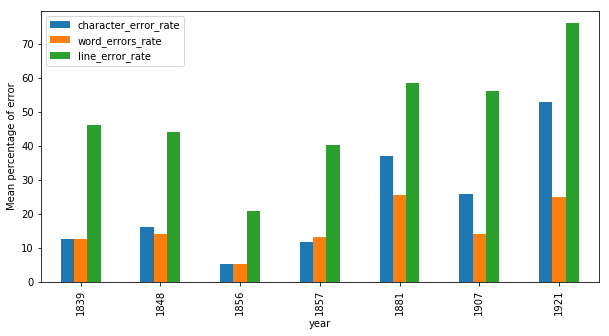

In [281]:
fig, ax = plt.subplots(figsize=(10,5))
df_per_doc.join(df_rep[['annee']]).sort_values(by='annee').reset_index().set_index(['annee']).plot(kind='bar', ax=ax)
plt.xlabel('year')
plt.ylabel('Mean percentage of error');